### Import Libraries

In [1]:
import os
import cv2
import math
import time
import tqdm
import tarfile
import numbers
import threading
import queue as Queue
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split, DataLoader, Dataset
from torchsummary import summary

In [2]:
import mxnet as mx
from mxnet import recordio

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
random_seed = 42
torch.manual_seed(random_seed);

In [5]:
torch.set_printoptions(edgeitems=5)

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True) #, dtype=torch.float

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
device = get_default_device()

In [8]:
device

device(type='cuda')

In [9]:
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

<b>Steps:</b>

    1. Dataset:
        a) Fetch/Download the Image dataset
        b) Visualize the dataset
        c) Preprocessing:
            i) Split dataset
            ii) Image augmentation
            iii) Data generator
    2. Model Architecture
        a) Network
        b) Loss Function
    3. Train model
    4. Evaluate model
        a) Plot Loss and Accuracy curves
    5. Visualize/Predict results on test sets

### Step 1a) Fetch the MS1M-ArcFace dataset

In [10]:
class ArcFaceDataset(Dataset):
    def __init__(self, root_dir):
        super(ArcFaceDataset, self).__init__()

        self.transform = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomHorizontalFlip(p=0.5),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
             ])
        
        self.root_dir = root_dir
        #root_dir2 = "D:/Face/faces_emore/" #"faces_emore/"
        
        path_imgrec = os.path.join(root_dir, 'train.rec')
        path_imgidx = os.path.join(root_dir, 'train.idx')
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
        s = self.imgrec.read_idx(0)
        header, _ = mx.recordio.unpack(s)
        
        if header.flag > 0:
            self.header0 = (int(header.label[0]), int(header.label[1]))
            self.imgidx = np.array(range(1, int(header.label[0])))
        else:
            self.imgidx = np.array(list(self.imgrec.keys)) #List of numbers 1 .... 5908396

    def __getitem__(self, index):
        idx = self.imgidx[index]
        s = self.imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        if not isinstance(label, numbers.Number):
            label = label[0]
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, label

    def __len__(self):
        return len(self.imgidx)

In [11]:
root_dir1 = "faces_emore/" #For Ubuntu
root_dir2 = "D:/Face/faces_emore/" #For Windows

dataset = ArcFaceDataset(root_dir1)

In [12]:
dataset

In [13]:
len(dataset)

5822653

### Step 1b) Visualize the dataset

In [14]:
plt.rcParams["figure.figsize"] = (5, 5)

In [15]:
img, label = dataset[0]
print(img.shape, label)

img = torch.permute(img, (1, 2, 0))
print(img.shape)

torch.Size([3, 112, 112]) tensor(0)
torch.Size([112, 112, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


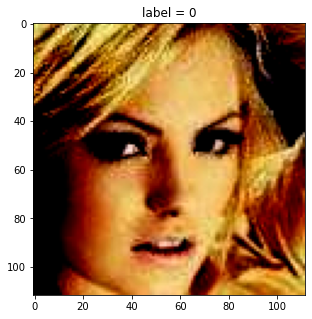

In [16]:
#Normalized image

plt.imshow(img)
plt.title('label = ' + str(label.item()))
plt.show()

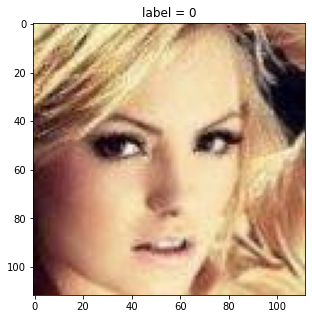

In [17]:
#Original image

img = (img*127)+127.5
img = img.type(torch.int64)
plt.imshow(img)
plt.title('label = ' + str(label.item()))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


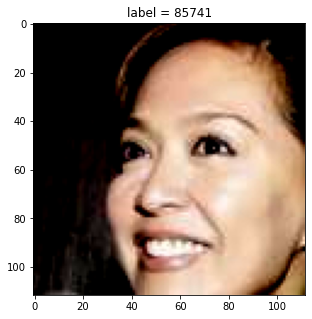

In [18]:
img, label = dataset[5822652]
#img = torch.reshape(img, (112, 112, 3))
img = torch.permute(img, (1, 2, 0))

#Normalized image
plt.imshow(img)
plt.title('label = ' + str(label.item()))
plt.show()

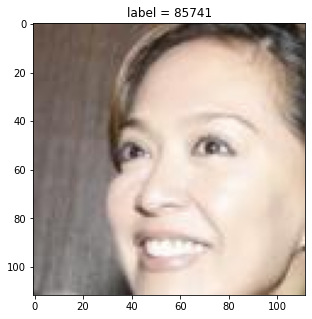

In [19]:
#Original image

img = (img*127)+127.5
img = img.type(torch.int64)
plt.imshow(img)
plt.title('label = ' + str(label.item()))
plt.show()

### Step 1c) Split the dataset into training, validation, and testing

In [20]:
#Limiting the dataset for computation purposes

lim_factor = 1 #Set to 1 for using the entire dataset
lim_size = int(lim_factor * len(dataset))
lim_dataset_size = len(dataset) - lim_size

large_ds, lim_ds = random_split(dataset, [lim_dataset_size, lim_size])

In [21]:
len(large_ds), len(lim_ds)

(0, 5822653)

In [22]:
test_factor = 0.1
test_size = int(test_factor * len(lim_ds))
train_size = len(lim_ds) - test_size
train_ds, test_ds = random_split(lim_ds, [train_size, test_size])

val_factor = 0.1
val_size = int(val_factor * len(lim_ds))
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

In [23]:
len(train_ds), len(val_ds), len(test_ds)

(4658123, 582265, 582265)

In [24]:
batch_size=256

In [25]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)

In [26]:
train_dl

In [27]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [28]:
len(train_dl), len(val_dl), len(test_dl)

(18196, 2275, 2275)

### Step 2a) Model Architecture - Network

In [29]:
def conv_2d(ni, nf, ks, stride=1):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf, ks):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                       nn.ReLU(inplace=True),
                       conv_2d(ni, nf, ks))

In [30]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        if ni > 100:
            temp = ni * 2
        else:
            temp = ni
        self.bn = nn.BatchNorm2d(temp)
        self.conv1 = conv_2d(temp, ni, 1, stride)
        self.conv2 = bn_relu_conv(ni, ni, ks=3)
        self.conv3 = bn_relu_conv(ni, nf, ks=1)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(temp, nf, 1, stride)

    def forward(self, x):
        #print("Inside Res Block1")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r1 = self.shortcut(x)
        #print(r1.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        #print(x.shape)
        return x.add_(r1)

In [31]:
class ResBlock2(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 1, stride)
        self.conv2 = bn_relu_conv(nf, nf, ks=3)
        self.conv3 = bn_relu_conv(nf, ni, ks=1)
        self.shortcut = lambda x: x
#        if ni != nf:
#            self.shortcut = conv_2d(ni, nf, 1, 1)

    def forward(self, x):
        #print("Inside Res Block2")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r = self.shortcut(x)
        #print(r.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        return x.add_(r)

In [32]:
def make_group(N, ni, nf, stride):
    start = ResBlock(ni, nf, stride)
    rest = [ResBlock2(nf, ni) for j in range(1, N)]
    return [start] + rest

In [33]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [34]:
# class MyResNet(nn.Module):
#     def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
#         super().__init__()
#         #Increase channels
#         layers = [conv_2d(3, 64, ks=7, stride=2)]
#         layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
#         n_channels = [n_start]

#         #Add groups
#         for i in range(n_groups):
#             n_channels.append(n_start*(2**i)*k)
#             stride = 2 if i>0 else 1
#             layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

#         #Pool, Flatten, and add linear layer for classification  
#         layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
#                    nn.ReLU(inplace=True),
#                    nn.AdaptiveAvgPool2d(1),
#                    #nn.AvgPool2d(kernel_size=2, stride=2), 
#                    Flatten(), 
#                    nn.Linear(n_channels[n_groups]*2, n_classes)]
    
#         self.features = nn.Sequential(*layers)
        
#     def forward(self, x):
#         #a = self.features(x)
#         #print(a.shape)
#         return self.features(x)

In [35]:
class MyResNet(nn.Module):
    def __init__(self, n_groups, N, k=1, n_start=64):
        super().__init__()
        #Increase channels
        self.layers = [conv_2d(3, 64, ks=7, stride=2)]
        self.layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            self.layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        self.layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                        nn.ReLU(inplace=True),
                        nn.AdaptiveAvgPool2d(1),
                        #nn.AvgPool2d(kernel_size=2, stride=2),
                        Flatten(),
                        nn.Linear(n_channels[n_groups]*2, 512)
                       ]
        #self.fc = nn.Linear(512, n_classes)
        self.features = nn.Sequential(*self.layers)
        
    def forward(self, x):
        embed = self.features(x)
        #print(embed.shape)
        return embed #self.fc(embed)

In [36]:
#Number of blocks at various groups
N_50 = [3, 4, 6, 3]
N_101 = [3, 4, 23, 3]
N_152 = [3, 8, 36, 3]

def ResNet50():
    return MyResNet(4, N_50, k=2)

def ResNet101():
    return MyResNet(4, N_101, k=2)

def ResNet152():
    return MyResNet(4, N_152, k=2)

In [37]:
# def test():
#     net = ResNet152(10)
#     x = torch.randn(2, 3, 224, 224)
#     y = net(x)
#     print(y.shape)
#     to_device(net, device)
#     summary(net, input_size = (3, 224, 224), batch_size = -1)
#     return net

In [38]:
# model_net = test()

In [39]:
# class ResNet_WIP(nn.Module):
#     def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
#         super().__init__()
#         #Increase channels
#         self.layers = [conv_2d(3, 64, ks=7, stride=2)]
#         self.layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
#         n_channels = [n_start]

#         #Add groups
#         for i in range(n_groups):
#             n_channels.append(n_start*(2**i)*k)
#             stride = 2 if i>0 else 1
#             self.layers += self.make_group(N[i], n_channels[i], n_channels[i]*4, stride)

#         #Pool, Flatten, and add linear layer for classification  
#         self.layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
#                    nn.ReLU(inplace=True),
#                    nn.AdaptiveAvgPool2d(1),
#                    #nn.AvgPool2d(kernel_size=2, stride=2), 
#                    Flatten(), 
#                    nn.Linear(n_channels[n_groups]*2, n_classes)]
#                    #nn.Softmax(dim=1)]
    
#         self.features = nn.Sequential(*self.layers)
        
#     def forward(self, x):
#         return self.features(x)

#     def make_group(self, N, ni, nf, stride):
#         start = ResBlock(ni, nf, stride)
#         rest = [ResBlock2(nf, ni) for j in range(1, N)]
#         return [start] + rest

In [40]:
model = ResNet101()
to_device(model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [41]:
summary(model, input_size = (3, 112, 112), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,408
         MaxPool2d-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4          [-1, 256, 28, 28]          16,384
            Conv2d-5           [-1, 64, 28, 28]           4,096
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,864
       BatchNorm2d-9           [-1, 64, 28, 28]             128
             ReLU-10           [-1, 64, 28, 28]               0
           Conv2d-11          [-1, 256, 28, 28]          16,384
         ResBlock-12          [-1, 256, 28, 28]               0
      BatchNorm2d-13          [-1, 256, 28, 28]             512
           Conv2d-14           [-1, 64,

In [42]:
# for images, labels in test_dl:
#     #print("Inside")
#     print('images.shape:', images.shape)
#     print('labels.shape:', labels.shape)
#     print('labels:', labels)
#     out = model(images)
#     print('out.shape:', out.shape)
#     print('out[0]:', out[0])
#     print('out[0].shape:', out[0].shape)
    
#     pre_sum = torch.sum(out, dim=1) #torch.sum(out[0], dim=0)
#     print('sum of out[0]:', pre_sum.shape)
    
#     F_sum = torch.sum(F.softmax(out, dim=1), dim=1)
#     print('softmax of out[0]:', F_sum.shape)
#     break

### Step 2b) Loss Function

In [43]:
# class CosFace(torch.nn.Module):
#     def __init__(self, s=64.0, m=0.35):
#         super(CosFace, self).__init__()
#         self.s = s
#         self.m = m

#     def forward(self, logits, labels):
#         index = torch.where(labels != -1)[0]
#         target_logit = logits[index, labels[index].view(-1)]
#         final_target_logit = target_logit - self.m
#         logits[index, labels[index].view(-1)] = final_target_logit
#         logits = logits * self.s
#         return logits

In [48]:
class SoftMax(nn.Module):
    def __init__(self, in_features=512, out_features=85742):
        super(SoftMax, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.kernel = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.normal_(self.kernel, std=0.01)

    def forward(self, logits, labels):
        logits = F.normalize(logits, p=2.0, dim=1)
        kernel_norm = F.normalize(self.kernel, p=2.0, dim=0)
        cos_theta = torch.mm(logits, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  #for numerical stability
        
        return cos_theta

In [45]:
class CosFace(nn.Module):
    def __init__(self, in_features=512, out_features=85742, s=64.0, m=0.35):
        super(CosFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.kernel = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.normal_(self.kernel, std=0.01)

    def forward(self, logits, labels):
        logits = F.normalize(logits, p=2.0, dim=1)
        kernel_norm = F.normalize(self.kernel, p=2.0, dim=0)
        cos_theta = torch.mm(logits, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  #for numerical stability
        index = torch.where(labels != -1)[0]
        m_hot = torch.zeros(index.size()[0], cos_theta.size()[1]).to(device)
        m_hot.scatter_(1, labels[index, None], self.m).to(device)
        cos_theta[index] -= m_hot
        ret = cos_theta * self.s
        return ret

In [46]:
class ArcFace(nn.Module):
    def __init__(self, in_features=512, out_features=85742, s=64.0, m=0.5):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.kernel = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.normal_(self.kernel, std=0.01)

    def forward(self, logits, labels):
        logits = F.normalize(logits, p=2.0, dim=1)
        kernel_norm = F.normalize(self.kernel, p=2.0, dim=0)
        cos_theta = torch.mm(logits, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  #for numerical stability
        index = torch.where(labels != -1)[0]
        m_hot = torch.zeros(index.size()[0], cos_theta.size()[1]).to(device)
        m_hot.scatter_(1, labels[index, None], self.m).to(device)
        cos_theta.acos_()
        cos_theta[index] += m_hot
        cos_theta.cos_().mul_(self.s)
        return cos_theta

In [49]:
new_logits = SoftMax()

In [50]:
to_device(new_logits, device)
#new_logits.to(device)

SoftMax()

In [51]:
loss_Function = F.cross_entropy

In [52]:
# checkpoint = torch.load("../Checkpoints/ResNet100_CosFace_24_Mar_36.pt")
# model.load_state_dict(checkpoint['model_state_dict'])
# epoch = checkpoint['epoch']
# #opt1 = checkpoint['model_optimizer_state_dict']
# #opt2 = checkpoint['fc_optimizer_state_dict']
# #opt2['state'][0]['momentum_buffer']
# new_logits = checkpoint['new_logits']
# #n.kernel.shape
# train_acc = checkpoint['train_acc']
# val_acc = checkpoint['val_acc']

In [53]:
# train_acc, val_acc, epoch

In [54]:
# to_device(model, device)
# to_device(new_logits, device)

### Step 3) Training the model

In [55]:
def loss_batch(model, loss_func, xb, yb, opt=None, opt_out=None, metric=None):
    #Generate predictions
    features = model(xb) #F.normalize(model(xb), p=2.0, dim=1)
    preds = new_logits(features, yb)
    
    #Generate probabilities
    #preds = F.softmax(preds, dim=1)
    
    #Calculate loss
    loss = loss_func(preds, yb)
    
    if opt is not None:
        #Compute gradients
        loss.backward()
        
        #Gradient Clipping
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=5, norm_type=2)
        
        #update parameters
        opt.step()
        opt_out.step()
        
        #Reset Gradients
        opt.zero_grad()
        opt_out.zero_grad()

    metric_result = None
    if metric is not None:
        #compute the metric
        metric_result = metric(preds, yb)
    
    #print(loss.is_cuda)
    #print(xb.is_cuda)
    #print(metric_result.is_cuda)
        
    return loss.item(), len(xb), metric_result

In [56]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        #pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        #separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        #Total size of the dataset
        total = np.sum(nums)
        #Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metric = None
        
        if metric is not None:
            #Avg of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total

    return avg_loss, total, avg_metric

In [57]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, lr=None, lr_func=None, metric=None, opt_fn=None):
    
    train_losses, train_metrics, val_losses, val_metrics = [], [], [], []
    
    #instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    opt_out = opt_fn(new_logits.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    
    scheduler_network = torch.optim.lr_scheduler.LambdaLR(optimizer=opt, lr_lambda=lr_func)
    scheduler_out = torch.optim.lr_scheduler.LambdaLR(optimizer=opt_out, lr_lambda=lr_func)
    
    for epoch in tqdm.tqdm(range(epochs)):
        #start = time.time()
        ep_train_losses, train_len, ep_train_metrics = [], [], []
        
        #Training
        model.train()
        for xb, yb in train_dl:
            train_loss, len_xb, train_metric = loss_batch(model, loss_fn, xb, yb, 
                                                          opt, opt_out, metric)
            ep_train_losses.append(train_loss)
            train_len.append(len_xb)
            ep_train_metrics.append(train_metric)
            
        scheduler_network.step()
        scheduler_out.step()
        
        total = np.sum(train_len)
        avg_train_loss = np.sum(np.multiply(ep_train_losses, train_len)) / total
        avg_train_metric = None
        if metric is not None:
            avg_train_metric = np.sum(np.multiply(ep_train_metrics, train_len)) / total

        #Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        #Record the loss and metric
        train_losses.append(avg_train_loss)
        train_metrics.append(avg_train_metric)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        
        #Checkpointing the model - saving every 'n' epochs
        checkpoint_path = "Checkpoints/ResNet100_SoftMax_30_Mar_" +str(epoch+1)+".pt"
        
        if ((epoch+1)%3 == 0):
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                #'model_optimizer_state_dict': opt.state_dict(),
                #'fc_optimizer_state_dict': opt_out.state_dict(),
                'new_logits': new_logits,
                'train_acc': avg_train_metric,
                'val_acc': val_metric,
            }, checkpoint_path)
        
        #end = time.time()

        #Print progress:
        if metric is None:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}'
                  .format(epoch+1, epochs, train_loss, val_loss))
            #print(str(round((end - start), 2)) + " secs")
        
        else:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}, Train_{}: {:.4f}, Val_{}: {:.4f}'
                  .format(epoch+1, epochs, avg_train_loss, val_loss, metric.__name__,  avg_train_metric, 
                          metric.__name__, val_metric))
            #print(str(round((end - start), 2)) + " secs")

    return train_losses, train_metrics, val_losses, val_metrics

In [58]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [59]:
val_loss, _, val_acc = evaluate(model, loss_Function, val_dl, metric=accuracy) #metric=None

In [60]:
#print('Loss: {:.4f}'.format(val_loss))
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 11.3601, Accuracy: 0.0000


In [61]:
opt_func = torch.optim.SGD

In [62]:
def lr_step_func(epoch):
    return ((epoch + 1) / (4 + 1)) ** 2 if epoch < -1 else 0.5 ** len(
        [m for m in [3,6,9,12,13] if m - 1 <= epoch])

In [63]:
#No dynamic updation in LR
def unit_lr(epoch):
    return 1

In [64]:
num_epochs = 13
lr = 0.01

In [65]:
history = fit(epochs=num_epochs, model=model, loss_fn=loss_Function, 
              train_dl=train_dl, valid_dl=val_dl, lr=lr, lr_func=lr_step_func, 
              metric=accuracy, opt_fn=opt_func)

  8%|███▎                                       | 1/13 [1:34:37<18:55:34, 5677.85s/it]

Epoch [1/13], Train_loss: 11.2252, Val_loss: 10.9758, Train_accuracy: 0.0003, Val_accuracy: 0.0007


 15%|██████▌                                    | 2/13 [3:07:32<17:09:51, 5617.44s/it]

Epoch [2/13], Train_loss: 10.6845, Val_loss: 10.5589, Train_accuracy: 0.0051, Val_accuracy: 0.0090


 23%|█████████▉                                 | 3/13 [4:40:29<15:33:08, 5598.83s/it]

Epoch [3/13], Train_loss: 10.5217, Val_loss: 10.5094, Train_accuracy: 0.0157, Val_accuracy: 0.0171


 31%|█████████████▏                             | 4/13 [6:13:24<13:58:25, 5589.55s/it]

Epoch [4/13], Train_loss: 10.5038, Val_loss: 10.5043, Train_accuracy: 0.0187, Val_accuracy: 0.0183


 38%|████████████████▌                          | 5/13 [7:46:21<12:24:39, 5584.89s/it]

Epoch [5/13], Train_loss: 10.4983, Val_loss: 10.5043, Train_accuracy: 0.0205, Val_accuracy: 0.0179


 46%|███████████████████▊                       | 6/13 [9:19:15<10:51:09, 5581.29s/it]

Epoch [6/13], Train_loss: 10.4798, Val_loss: 10.4918, Train_accuracy: 0.0320, Val_accuracy: 0.0223


 54%|███████████████████████▏                   | 7/13 [10:52:13<9:18:00, 5580.10s/it]

Epoch [7/13], Train_loss: 10.4787, Val_loss: 10.4869, Train_accuracy: 0.0327, Val_accuracy: 0.0328


 62%|██████████████████████████▍                | 8/13 [12:25:23<7:45:15, 5583.12s/it]

Epoch [8/13], Train_loss: 10.4794, Val_loss: 10.5502, Train_accuracy: 0.0338, Val_accuracy: 0.0171


 69%|█████████████████████████████▊             | 9/13 [13:58:21<6:12:06, 5581.53s/it]

Epoch [9/13], Train_loss: 10.4660, Val_loss: 10.4698, Train_accuracy: 0.0474, Val_accuracy: 0.0450


 77%|████████████████████████████████▎         | 10/13 [15:31:16<4:38:58, 5579.51s/it]

Epoch [10/13], Train_loss: 10.4646, Val_loss: 10.4723, Train_accuracy: 0.0480, Val_accuracy: 0.0436


 85%|███████████████████████████████████▌      | 11/13 [17:04:16<3:05:59, 5579.64s/it]

Epoch [11/13], Train_loss: 10.4640, Val_loss: 10.4706, Train_accuracy: 0.0491, Val_accuracy: 0.0521


 92%|██████████████████████████████████████▊   | 12/13 [18:37:18<1:33:00, 5580.42s/it]

Epoch [12/13], Train_loss: 10.4551, Val_loss: 10.4628, Train_accuracy: 0.0606, Val_accuracy: 0.0527


100%|████████████████████████████████████████████| 13/13 [20:10:13<00:00, 5585.66s/it]

Epoch [13/13], Train_loss: 10.4488, Val_loss: 10.4563, Train_accuracy: 0.0682, Val_accuracy: 0.0630


In [66]:
train_losses, train_metrics, val_losses, val_metrics = history

In [67]:
# Creating a new data frame
newDataframe = pd.DataFrame()
filename = "ResNet100_SoftMax_30_Mar_outputs_data.xlsx"

newDataframe['Train Loss'] = train_losses
newDataframe['Val Loss'] = val_losses
newDataframe['Train Acc.'] = train_metrics
newDataframe['Val Acc.'] = val_metrics

# Converting the data frame to an excel file
newDataframe.to_excel(filename, index = False)

# Reading the data from the outputExcelFile
excelData = pd.read_excel(filename)

#Printing the data frame
print(excelData)

    Train Loss   Val Loss  Train Acc.  Val Acc.
0    11.225234  10.975765    0.000268  0.000694
1    10.684471  10.558916    0.005140  0.009039
2    10.521689  10.509357    0.015748  0.017140
3    10.503787  10.504296    0.018703  0.018291
4    10.498285  10.504336    0.020525  0.017908
5    10.479770  10.491765    0.031968  0.022287
6    10.478654  10.486881    0.032719  0.032781
7    10.479354  10.550213    0.033756  0.017090
8    10.465959  10.469766    0.047414  0.044980
9    10.464571  10.472302    0.048015  0.043595
10   10.464005  10.470644    0.049086  0.052067
11   10.455066  10.462777    0.060551  0.052680
12   10.448809  10.456348    0.068250  0.062973


### Step 4) Evaluate the model and Plotting of curves

In [68]:
def plot_accuracies(epoch, train_metrics, val_metrics):
    #accuracies = [x['val_metrics'] for x in history]
    x = np.arange(1, epoch+1, 1)
    plt.plot(x, train_metrics, '-bx')
    plt.plot(x, val_metrics, '-rx')
    
    plt.tick_params(labelcolor='g')
    plt.xticks(np.linspace(1, epoch, epoch))
    
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

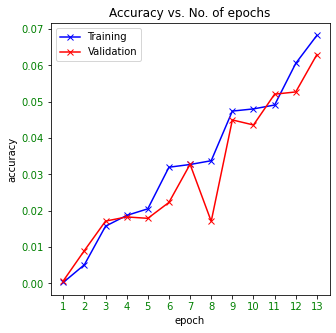

In [69]:
plot_accuracies(num_epochs, train_metrics, val_metrics)

In [70]:
def plot_losses(epoch, train_losses, val_losses):
    #train_losses = [x.get('train_losses') for x in history]
    #val_losses = [x['val_losses'] for x in history]
    x = np.arange(1, epoch+1, 1)
    
    plt.plot(x, train_losses, '-bx')
    plt.plot(x, val_losses, '-rx')
    
    plt.tick_params(labelcolor='g')
    plt.xticks(np.linspace(1, epoch, epoch))
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

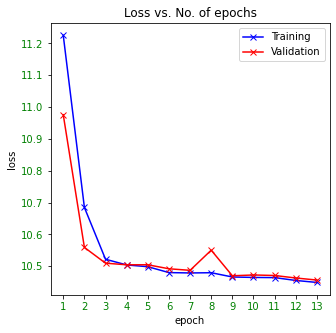

In [71]:
plot_losses(num_epochs, train_losses, val_losses)

In [72]:
result = evaluate(model, loss_Function, test_dl, accuracy)
print('Test_loss: {:.4f}, Test_acc.: {:.4f}'.format(result[0], result[2]))

Test_loss: 10.4559, Test_acc.: 0.0634


In [73]:
#Save the latest model

saved_path = "Checkpoints/ResNet100_SoftMax_30_Mar_" +str(num_epochs)+".pt"

torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    #'model_optimizer_state_dict': opt.state_dict(),
    #'fc_optimizer_state_dict': opt_out.state_dict(),
    'new_logits': new_logits,
    'train_acc': train_metrics[-1],
    'val_acc': val_metrics[-1],
}, saved_path)

In [74]:
#torch.save(model.state_dict(), 'model_01_mar.pth')

In [75]:
#torch.save(new_logits, 'kernel_weights_model_01_mar.pt')

### T-SNE Visualization

In [76]:
# checkpoint = torch.load("Checkpoints/ResNet50_CosFacev2/512-d-2/ResNet50_CosFace_20_Mar_36.pt")
# model.load_state_dict(checkpoint['model_state_dict'])
# epoch = checkpoint['epoch']
# #opt1 = checkpoint['model_optimizer_state_dict']
# #opt2 = checkpoint['fc_optimizer_state_dict']
# #opt2['state'][0]['momentum_buffer']
# new_logits = checkpoint['new_logits']
# #n.kernel.shape
# train_acc = checkpoint['train_acc']
# val_acc = checkpoint['val_acc']

In [77]:
# train_acc, val_acc, epoch

In [78]:
# to_device(model, device)
# to_device(new_logits, device)

In [79]:
data_ds = DataLoader(dataset, batch_size, shuffle=False, num_workers=4, pin_memory=True)
data_dl = DeviceDataLoader(data_ds, device)
len(data_dl)

22745

In [80]:
def tsne(model, new_logits, dataLoader):
    test_predictions = []
    test_targets = []
    test_embeddings = torch.empty((0, 512))
    
    ls = torch.empty((0))
    cnt = 1
    upto = 6
    
    with torch.no_grad():
        #set the model in evaluation mode
        model.eval()
    
        for xb, yb in dataLoader:
            ls = torch.cat((ls, yb.detach().cpu()), 0)
            
            features = model(xb)
            pred = new_logits(features, yb)
            softmax = F.softmax(pred, dim=1)
            max_value = torch.max(softmax, dim=1)[1]
            #print(max_value.shape)

            test_predictions.extend(max_value.detach().cpu().tolist())
            test_targets.extend(yb.detach().cpu().tolist())
            test_embeddings = torch.cat((test_embeddings, features.detach().cpu()), 0)
            
            cnt += 1
            if cnt>upto:
                break
                
    tsne_classes = len(np.unique(ls.cpu().numpy()))
    test_embeddings = np.array(test_embeddings)
    test_targets = np.array(test_targets)
    test_predictions = np.array(test_predictions)

    return tsne_classes, test_embeddings, test_targets, test_predictions

In [81]:
tsne_classes, test_embeddings, test_targets, test_predictions = tsne(model, 
                                                                     new_logits, data_dl)

In [82]:
print(tsne_classes)
print(len(test_embeddings))
print(len(test_targets))
print(len(test_predictions))

print(test_embeddings[0].shape)

22
1536
1536
1536
(512,)


In [83]:
def tsne_display(tsne_classes, test_embeddings, test_predictions):
    # Create a two dimensional t-SNE projection of the embeddings
    tsne = TSNE(2, verbose=1)
    tsne_proj = tsne.fit_transform(test_embeddings)

    # Plot those points as a scatter plot and label them based on the pred labels
    cmap = cm.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(8,8))
    num_categories = tsne_classes

    for lab in range(num_categories):
        indices = test_predictions==lab
        ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], 
                   c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
    ax.legend(fontsize='large', markerscale=2)
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1536 samples in 0.002s...
[t-SNE] Computed neighbors for 1536 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1536
[t-SNE] Computed conditional probabilities for sample 1536 / 1536
[t-SNE] Mean sigma: 0.013619
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.234360
[t-SNE] KL divergence after 1000 iterations: 0.342365


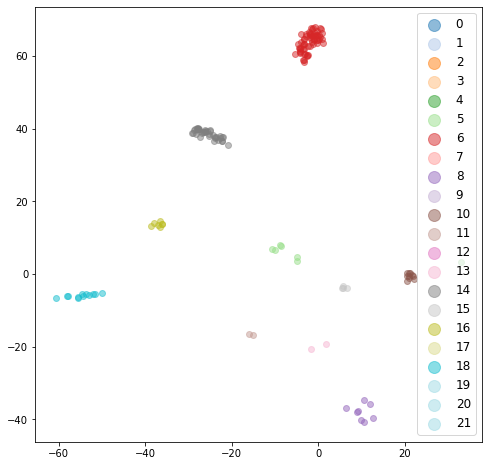

In [84]:
tsne_display(tsne_classes, test_embeddings, test_predictions)

### Load the saved model

In [85]:
# checkpoint = torch.load("Checkpoints/model_28_0.pt")
# model.load_state_dict(checkpoint['model_state_dict'])
# epoch = checkpoint['epoch']
# #opt1 = checkpoint['model_optimizer_state_dict']
# #opt2 = checkpoint['fc_optimizer_state_dict']
# #opt2['state'][0]['momentum_buffer']
# new_logits = checkpoint['new_logits']
# #n.kernel.shape
# acc = checkpoint['acc']

In [86]:
# acc, epoch

In [87]:
# loaded_model = ResNet50(85742)
# to_device(loaded_model, device)

In [88]:
# loaded_model.load_state_dict(torch.load("CosFace-v2/model_28.pth"))
# new_logits = torch.load("CosFace-v2/kernel_weights_model_28.pt")

In [89]:
# new_logits.kernel.shape

In [90]:
# loaded_model.eval()

In [91]:
# val_loss2, _, val_acc2 = evaluate(loaded_model, loss_Function, val_dl, metric=accuracy) #metric=None

In [92]:
# #print('Loss: {:.4f}'.format(val_loss))
# print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss2, val_acc2))

In [93]:
# result2 = evaluate(loaded_model, loss_Function, test_dl, accuracy)
# result2

### Step 5) Displaying results

In [94]:
def create_list(root_dir):
    img_list = []
    #%% 1 ~ 5908396, or 0~5908395, #85742 identities
    path_imgidx = os.path.join(root_dir, 'train.idx')
    path_imgrec = os.path.join(root_dir, 'train.rec')
    imgrec = recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
    
    for i in range(5822653):
        header, s = recordio.unpack(imgrec.read_idx(i+1))
        img_list.append(header.label)
        
    lst = np.array(img_list)
    
    return imgrec, lst

In [95]:
def fetch_pred_image(imgrec, lst, idx):
    idxs = np.where(lst==idx)[0]
    
    header, s = recordio.unpack(imgrec.read_idx(idxs[-1]))
    img = mx.image.imdecode(s).asnumpy()
    
    return img

In [96]:
#plt.rcParams["figure.figsize"] = (15, 15)

In [97]:
def prepare_plot(image, origTarget, predTarget, imgrec, lst, size=5):
    plt.rcParams["figure.figsize"] = (15*size/25, 15*size/5)
    rand = np.random.randint(0, 128, size)
    
    for i in range(size):
        img_fetch = fetch_pred_image(imgrec, lst, predTarget[rand[i]])
        plt.subplot(size, 3, 3*i+1)
        plt.imshow(image[rand[i]])
        plt.axis('off')
        plt.title('Actual id: ' + str(origTarget[rand[i]]))
        
        plt.subplot(size, 3, 3*i+2)
        plt.imshow(np.real(img_fetch))
        plt.axis('off')
        plt.title('Predicted id: ' + str(predTarget[rand[i]]))
        
        plt.subplot(size, 3, 3*i+3)
        plt.axis('off')
        if(origTarget[rand[i]] == predTarget[rand[i]]):
            plt.title('MATCHED!', fontsize = 12, color='g')
        else:
            plt.title('MIS-MATCHED!', fontsize = 15, color='r')
    
    plt.show()

In [98]:
def make_predictions(model, new_logits, dataLoader, data_dir, size=5):
    with torch.no_grad():
        #set the model in evaluation mode
        model.eval()
        
        for xb, yb in dataLoader:
            features = model(xb)
            pred = new_logits(features, yb)
            
            softmax = F.softmax(pred, dim=1)
            #sum_check = torch.sum(softmax, dim=1)
            #print(sum_check)
            max_value = torch.max(softmax, dim=1)[1]
            ##print("Predicted labels: ", max_value)
            ##print("Actual labels: ", yb)
            
            matches = max_value == yb
            #print(matches)
        
#             print(pred.shape)
#             print(pred[100].shape)
#             print(torch.max(pred[100]))
#             softmax = F.softmax(pred[100], dim=0)
#             max_value = torch.max(softmax)
#             print(max_value)
#             print("Actual label: ", yb[100].item())
#             index = torch.where(softmax == max_value)[0]
#             print("Predicted label: ", index.item())

            invTransform = transforms.Compose(
                [transforms.Normalize(mean=[0., 0., 0.], std=[1/0.5, 1/0.5, 1/0.5]),
                 transforms.Normalize(mean=[-0.5, -0.5, -0.5], std=[1, 1, 1]),
                ])
            xb = invTransform(xb)
    
            xb = xb.cpu().numpy() #Convert the tensor input into a numpy object
            #print(xb.shape)

            xb = np.transpose(xb, (0, 2, 3, 1)) #Shifting the channel into the 3rd dimension       
            #print(xb.shape)

            yb = yb.cpu().numpy() #Convert the tensor input into a numpy object
            #print(yb[0])

            max_value = max_value.cpu().numpy() #Convert the tensor input into a numpy object
            #print(max_value[0])
            
            imgrec, lst = create_list(data_dir)

            prepare_plot(xb, yb, max_value, imgrec, lst, size)
            
            break

In [99]:
#make_predictions(loaded_model, test_dl, 30)

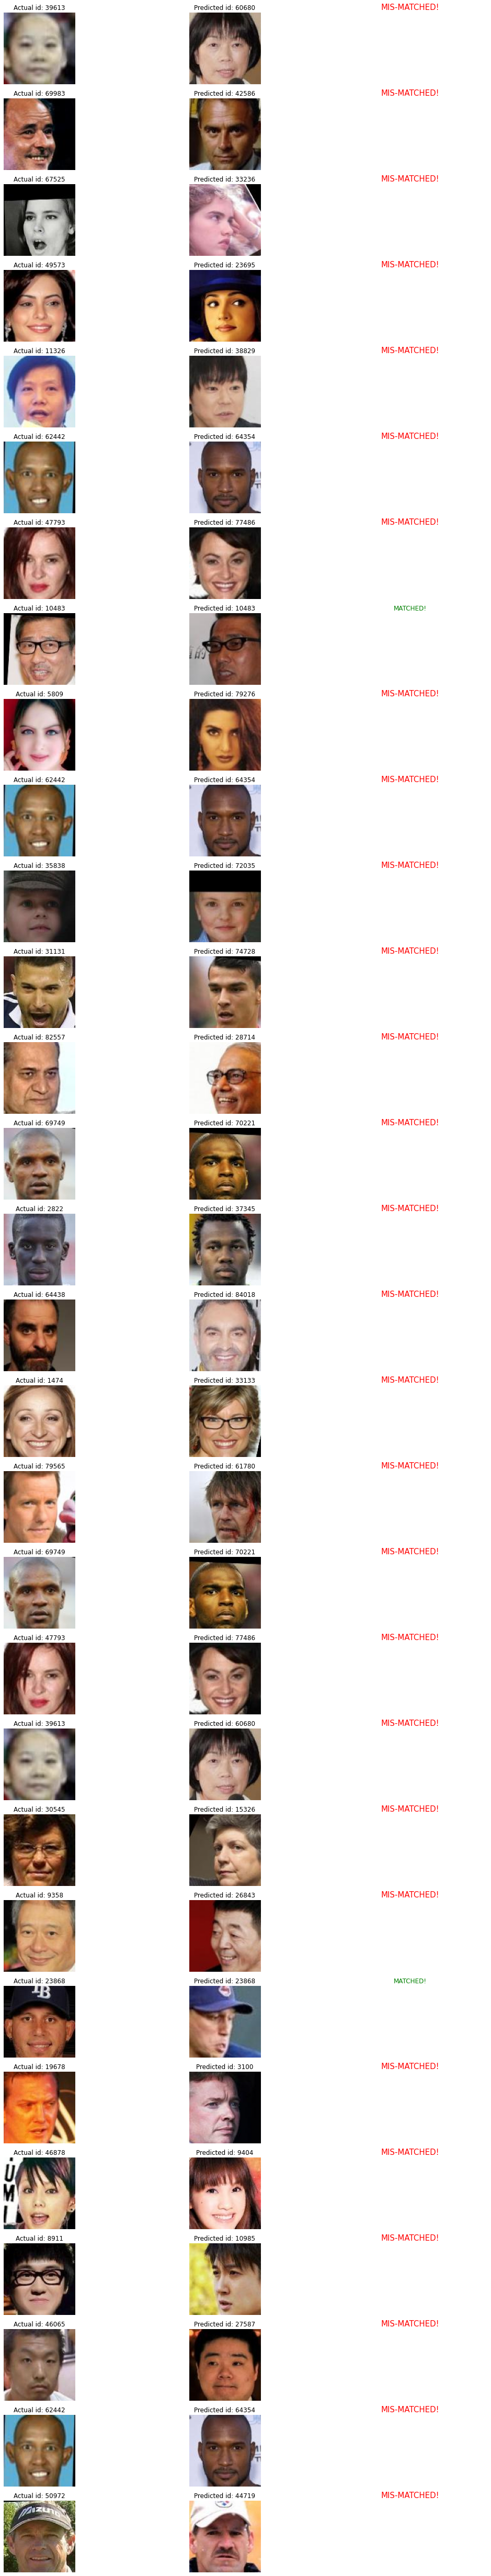

In [100]:
make_predictions(model, new_logits, test_dl, root_dir1, 30)